In [1]:
###################################################
import emcee
import numpy as np
import scipy

from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time
from astropy.coordinates import SkyCoord
import astropy.units as u
import pyccl as ccl
import clevar
import numpy as np
from astropy.table import Table
import clmm
from clevar.catalog import ClCatalog, MemCatalog
from clevar.match_metrics import recovery
import matplotlib.pyplot as plt
from clevar.match import MembershipMatch
from clevar.match_metrics import distances
from clevar.match_metrics import scaling
from clevar.match import ProximityMatch
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
###################################################

## Loading catalogs. Not needed 

In [2]:
# import numpy as np
# import matplotlib as mpl
# import sys
# sys.path.append("/sps/lsst/users/maguena/git_codes/wazp_dc2_paper/src_files/")
# import pyscritps as paper_tools
# from pyscritps import gaussian_paper as gp
# import clevar

# dc2dir = "/sps/lsst/users/maguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full"
# cpath = f"{dc2dir}/wazp/pywazp_gaussian_new"
# hpath = f"{dc2dir}/halos"
# mt_path = "/sps/lsst/users/maguena/working/wazp_dc2/pywazp_new/"

# # select which pz scatter case to be used
# cases = ("010", "015", "020", "030", "050")

# # read catalogs
# data = gp.core.MainData(cpath, hpath, cases, mt_path=mt_path)

# # # Match catalogs
# data.load_match()


# # Compute max share fraction
# data.load_match_input()
# data.add_shared_frac_max()

# # Get matched pairs
# from clevar.match import get_matched_pairs



Remove duplicates
165,076
165,033


*** 010 ***
WaZP
    * ClEvar used in matching: 0.17.1
 * Total objects:    408,092
 * multiple (self):  111,245
 * multiple (other): 111,245
 * unique (self):    93,048
 * unique (other):   93,088
 * cross:            93,024

Halo
    * ClEvar used in matching: 0.17.1
 * Total objects:    165,033
 * multiple (self):  96,213
 * multiple (other): 96,213
 * unique (self):    93,088
 * unique (other):   93,048
 * cross:            93,024


*** 015 ***
WaZP
    * ClEvar used in matching: 0.17.1
 * Total objects:    354,187
 * multiple (self):  112,585
 * multiple (other): 112,585
 * unique (self):    90,890
 * unique (other):   90,949
 * cross:            90,844

Halo
    * ClEvar used in matching: 0.17.1
 * Total objects:    165,033
 * multiple (self):  95,000
 * multiple (other): 95,000
 * unique (self):    90,949
 * unique (other):   90,890
 * cross:            90,844


*** 020 ***
WaZP
    * ClEvar used in matching: 0.17.1
 * Total objects:    308,18

In [11]:
# def get_matched_catalogs(wazp, halos, sig):
#     h, w = get_matched_pairs(
#         halos,
#         wazp[sig],
#         f"cross.sig{sig}",
#     )
#     return h,w
# cat1, cat2 = get_matched_catalogs(data.wazp, data.halos, '010')
# cols_to_remove = [c for c in cat1.colnames if 'sig' in c]

# for col in cols_to_remove:
#     del cat1[col]

# cols_to_remove = [c for c in data.halos.colnames if 'sig' in c]

# for col in cols_to_remove:
#     del data.halos[col]
    
# cat1.write("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_halo_catalog.fits", overwrite=True)
# cat2.write("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_cluster_010_photoz_catalog.fits", overwrite=True)
# data.halos.write("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/cosmodc2_halo_catalog.fits", overwrite=True)
# data.wazp['010'].write("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/cluster_010_photoz_catalog.fits", overwrite=True)

# mask = (cat2["mt_cross"] != -1) & (cat2["mt_cross"] != None)
# cat_halo_cluster_match = cat2[mask]

# cat_halo_cluster_match["m200c"]     = np.full(len(cat_halo_cluster_match), -1., dtype=float)
# cat_halo_cluster_match["halo_mass"]     = np.full(len(cat_halo_cluster_match), -1., dtype=float)
# cat_halo_cluster_match["z_h"]       = np.full(len(cat_halo_cluster_match), -1., dtype=float)
# cat_halo_cluster_match["ra_true"]   = np.full(len(cat_halo_cluster_match), -1., dtype=float)
# cat_halo_cluster_match["dec_true"]  = np.full(len(cat_halo_cluster_match), -1., dtype=float)
# cat_halo_cluster_match["NMEM_true"] = np.full(len(cat_halo_cluster_match), -1, dtype=int)  # richness is int
# display(cat_halo_cluster_match[cat_halo_cluster_match["mt_cross"] == str(7300151475)])

# m200c_halos = Table.read("/sps/lsst/users/maguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")
# cat_halo_cluster_match["mt_cross"] = cat_halo_cluster_match["mt_cross"].astype(int)
# cat1["halo_id"] = cat1["halo_id"].astype(int)
# m200c_halos["halo_id"] = m200c_halos["halo_id"].astype(int)
# display(m200c_halos)
# j = 0
# for i, halo_idx in enumerate(cat_halo_cluster_match["mt_cross"]):

#     halo_row = cat1[cat1["halo_id"] == halo_idx]
#     m200c_row = m200c_halos[m200c_halos["halo_id"] == halo_idx]
#     if len(halo_row) != 1:
#         raise ValueError(f"halo_id {halo_idx} matched {len(halo_row)} rows")
#     halo_row = cat1[cat1["halo_id"] == halo_idx]
#     m200c_row = m200c_halos[m200c_halos["halo_id"] == halo_idx]

#     if len(halo_row) != 1:
#         raise ValueError(f"halo_id {halo_idx} matched {len(halo_row)} rows in cat1")

#     if len(m200c_row) != 1:
#         m200c_value = -1.0
#         j+=1
#     else:
#         m200c_value = m200c_row["m200c"][0]
#     cat_halo_cluster_match["halo_mass"][i]    = halo_row["halo_mass"][0]
#     cat_halo_cluster_match["m200c"][i]        = m200c_value # <-- extract scalar
#     cat_halo_cluster_match["z_h"][i]          = halo_row["redshift_true"][0]
#     cat_halo_cluster_match["ra_true"][i]      = halo_row["ra_true"][0]
#     cat_halo_cluster_match["dec_true"][i]     = halo_row["dec_true"][0]
#     cat_halo_cluster_match["NMEM_true"][i]    = halo_row["NMEM_z_star2"][0]
#     print(j)
# display(cat_halo_cluster_match)
# cat_halo_cluster_match.write(
#     "/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_halo_cluster_catalog.fits",
#     overwrite=True
# )


ERROR! Session/line number was not unique in database. History logging moved to new session 2898


halo_id,ra_true,dec_true,ra,dec,redshift_true,mass_fof,m200c,r200c,skysim_halo_id,NMEM,richness,NMEM_g_star2,NMEM_r_star2,NMEM_i_star2,NMEM_z_star2,NMEM_y_star2,richness_g_star2,richness_r_star2,richness_i_star2,richness_z_star2,richness_y_star2,ra_bary,dec_bary
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
1600020475,50.77596621112012,-27.11267297840223,50.775875822529436,-27.112584328955446,0.04530489444732666,2.247e+13,18901145086557.746,0.5539122181878964,4308786475,14,8.259415690053675,4,2,2,2,2,3.3159297517335684,2.0,2.0,2.0,2.0,50.86080257640612,-27.111068884566034
2700020475,49.46685631106464,-25.960657456295777,49.466814189348334,-25.960541211222015,0.04615640640258789,1.633e+13,15062094204754.93,0.5136732064502341,5608786475,14,7.310438276043445,7,5,5,5,5,3.9505018568471444,3.162710828265532,3.162710828265532,3.162710828265532,3.162710828265532,49.430749682006216,-26.004253136511434
17200020453,50.16400668612118,-25.25905307744378,50.16585579512233,-25.259404686564693,0.08653247356414795,2.283e+13,20441971397588.734,0.5883426733419929,9508786453,12,5.623277102797734,5,5,5,4,4,3.3387389360236903,3.3387389360236903,3.3387389360236903,3.130245439035445,3.130245439035445,50.10887874151731,-25.222612608640762
19000020453,49.51595503782168,-26.130631687629403,49.51865674267036,-26.131426039026245,0.09413313865661621,1.199e+13,10668658238016.902,0.47378993370163613,29908786453,15,6.997234500189672,7,7,7,7,7,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,49.526283728873516,-26.143323644925193
19800020453,50.68971804154461,-26.886508987581664,50.691634217578326,-26.88681304144144,0.08739697933197021,8.412e+13,71624983358738.03,0.8935768839339135,10408786453,25,10.377440167337566,12,11,9,8,8,5.102184303491505,4.807846043434688,4.353673518160678,4.0503547588246684,4.0503547588246684,50.71067924047927,-26.883765517046655
32800020453,51.49229315287324,-26.308837160731073,51.49405530538187,-26.309071814426567,0.08795535564422607,1.328e+13,10371945197971.832,0.4693405728944591,14908786453,7,4.078294904689155,2,2,2,2,2,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,51.53207787114288,-26.281769096943737
2000020442,51.02799219278836,-25.768148487504888,51.03054382968504,-25.767733992572435,0.10751283168792725,3.555e+13,31256384653340.848,0.6889763852240335,9408786442,22,9.068648511775608,3,3,3,3,2,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.5330209172234177,51.04052597864433,-25.76994686512187
32300020442,51.47772552281113,-25.82579874206229,51.48013416475692,-25.825311694587846,0.10751473903656006,1.339e+13,11587427913554.93,0.49502278717470843,43208786442,10,5.4538674639470575,5,4,4,3,3,3.6826146155436636,2.6826146155436636,2.6826146155436636,2.0956992167416817,2.0956992167416817,51.46172414586285,-25.805957090122217
33300020442,50.31241043560731,-26.69591460405023,50.315518939516316,-26.69559169836869,0.108817458152771,3.434e+13,29876928281239.438,0.6786574780101507,44708786442,16,6.788349932828027,8,8,8,8,8,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,50.28802465790821,-26.712593565283026


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
5
5
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
15
15
15
15
15
16
16
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
19
19
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21

In [12]:
from astropy.table import Table

t_cl_halo_match = Table.read("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_halo_cluster_catalog.fits")

t_cl = Table.read("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_cluster_010_photoz_catalog.fits")

t_halo = Table.read("/sps/lsst/groups/clusters/cl_pipeline_project/pywazp_gaussian_catalogs/matched_halo_catalog.fits")
display(t_cl_halo_match)
t_cl_halo_match = t_cl_halo_match[t_cl_halo_match['m200c'] != -1.0]
display(t_cl_halo_match)
Mp, zp = 10**14.3, 0.5

###################################################
coord_cl = SkyCoord(t_cl_halo_match['ra'], t_cl_halo_match['dec'], unit='deg')
coord_h  = SkyCoord(t_cl_halo_match['ra_true'], t_cl_halo_match['dec_true'], unit='deg')

sep = coord_cl.separation(coord_h)
print("Median sep:", np.median(sep.to(u.arcmin)))
print("Max sep:", np.max(sep.to(u.arcmin)))

ra,dec,zp,n200,r200_mpc,id,snr,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_frac_self,mt_frac_other,mt_cross,mt_frac_self_max,mt_frac_other_max,m200c,halo_mass,z_h,ra_true,dec_true,NMEM_true
float64,float64,float32,float32,float32,bytes30,float32,bytes13,bytes13,bytes109,bytes109,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64
50.93591472649795,-41.34538693217072,0.05277125,14.847,1.122,143476,5.502,7300151475,7300151475,7300151475,7300151475,0.4725516024109578,0.2653061224489796,7300151475,0.4725516024109578,0.2653061224489796,63046332035245.07,74621860826501.4,0.04803776741027832,50.957678900761394,-41.3448059771583,13
49.49706323474621,-40.242985768257384,0.115748845,8.003,0.968,79349,6.684,43700151442,43700151442,43700151442,43700151442,0.7942936216414986,0.2127659574468085,43700151442,0.7942936216414986,0.2127659574468085,60807967862264.79,69213477135143.664,0.11421597003936768,49.50377592935664,-40.240490667975706,12
51.11978122453714,-39.620245431872505,0.14177611,7.075,0.861,154590,5.357,52300151442,52300151442,52300151442,52300151442,0.6244911071454774,0.20689655172413793,52300151442,0.6244911071454774,0.20689655172413793,58720563188461.98,62974036412214.086,0.1259174346923828,51.06907727982047,-39.64607328475867,16
50.530714428897404,-39.75747779430141,0.16513884,12.868,1.086,6608,13.427,70700151421,70700151421,70700151421,70700151421,0.7217595669711405,0.38461538461538464,70700151421,0.7217595669711405,0.38461538461538464,68254428849397.19,119985568407436.62,0.16475677490234375,50.52541974335929,-39.759854374325954,16
50.538536858117084,-39.068128185514055,0.22151783,28.22,1.026,15444,10.683,78600151411,78600151411,78600151411,78600151411,0.49027272998606314,0.3118279569892473,78600151411,0.49027272998606314,0.3118279569892473,120390041092326.77,148634909566197.2,0.21005773544311523,50.54038986767568,-39.0704158967892,31
50.17085292813019,-39.51418400574235,0.20489573,40.267,1.249,4532,14.847,95400151411,95400151411,95400151411,95400151411,0.8417974135174581,0.37662337662337664,95400151411,0.8417974135174581,0.37662337662337664,222022091351977.47,228279662101633.8,0.2076319456100464,50.170338564932,-39.51566808485035,59
50.63606969044204,-41.40247981147909,0.19032279,71.619,1.663,1341,20.345,130200151411,130200151411,130200151411,130200151411,0.7262666073048916,0.41089108910891087,130200151411,0.7262666073048916,0.41089108910891087,229655937300912.7,263934081687436.62,0.19159162044525146,50.64208660915858,-41.40265859512897,84
51.192978766528704,-40.8759233021217,0.17799073,12.546,1.08,25735,9.285,191900151411,191900151411,191900151411,191900151411,0.8547775541627649,0.4074074074074074,191900151411,0.8547775541627649,0.4074074074074074,116379211308709.86,127931588723380.28,0.18677890300750732,51.19489753953479,-40.87828426780436,24
50.13097168819828,-41.25581068917369,0.20250845,16.688,0.84,33799,8.605,253900151411,253900151411,253900151411,253900151411,0.3668106354029247,0.3611111111111111,253900151411,0.3668106354029247,0.3611111111111111,58288508524169.016,70912063920676.06,0.19323325157165527,50.13040773558871,-41.24880382828121,13


ra,dec,zp,n200,r200_mpc,id,snr,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_frac_self,mt_frac_other,mt_cross,mt_frac_self_max,mt_frac_other_max,m200c,halo_mass,z_h,ra_true,dec_true,NMEM_true
float64,float64,float32,float32,float32,bytes30,float32,bytes13,bytes13,bytes109,bytes109,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64
50.93591472649795,-41.34538693217072,0.05277125,14.847,1.122,143476,5.502,7300151475,7300151475,7300151475,7300151475,0.4725516024109578,0.2653061224489796,7300151475,0.4725516024109578,0.2653061224489796,63046332035245.07,74621860826501.4,0.04803776741027832,50.957678900761394,-41.3448059771583,13
49.49706323474621,-40.242985768257384,0.115748845,8.003,0.968,79349,6.684,43700151442,43700151442,43700151442,43700151442,0.7942936216414986,0.2127659574468085,43700151442,0.7942936216414986,0.2127659574468085,60807967862264.79,69213477135143.664,0.11421597003936768,49.50377592935664,-40.240490667975706,12
51.11978122453714,-39.620245431872505,0.14177611,7.075,0.861,154590,5.357,52300151442,52300151442,52300151442,52300151442,0.6244911071454774,0.20689655172413793,52300151442,0.6244911071454774,0.20689655172413793,58720563188461.98,62974036412214.086,0.1259174346923828,51.06907727982047,-39.64607328475867,16
50.530714428897404,-39.75747779430141,0.16513884,12.868,1.086,6608,13.427,70700151421,70700151421,70700151421,70700151421,0.7217595669711405,0.38461538461538464,70700151421,0.7217595669711405,0.38461538461538464,68254428849397.19,119985568407436.62,0.16475677490234375,50.52541974335929,-39.759854374325954,16
50.538536858117084,-39.068128185514055,0.22151783,28.22,1.026,15444,10.683,78600151411,78600151411,78600151411,78600151411,0.49027272998606314,0.3118279569892473,78600151411,0.49027272998606314,0.3118279569892473,120390041092326.77,148634909566197.2,0.21005773544311523,50.54038986767568,-39.0704158967892,31
50.17085292813019,-39.51418400574235,0.20489573,40.267,1.249,4532,14.847,95400151411,95400151411,95400151411,95400151411,0.8417974135174581,0.37662337662337664,95400151411,0.8417974135174581,0.37662337662337664,222022091351977.47,228279662101633.8,0.2076319456100464,50.170338564932,-39.51566808485035,59
50.63606969044204,-41.40247981147909,0.19032279,71.619,1.663,1341,20.345,130200151411,130200151411,130200151411,130200151411,0.7262666073048916,0.41089108910891087,130200151411,0.7262666073048916,0.41089108910891087,229655937300912.7,263934081687436.62,0.19159162044525146,50.64208660915858,-41.40265859512897,84
51.192978766528704,-40.8759233021217,0.17799073,12.546,1.08,25735,9.285,191900151411,191900151411,191900151411,191900151411,0.8547775541627649,0.4074074074074074,191900151411,0.8547775541627649,0.4074074074074074,116379211308709.86,127931588723380.28,0.18677890300750732,51.19489753953479,-40.87828426780436,24
50.13097168819828,-41.25581068917369,0.20250845,16.688,0.84,33799,8.605,253900151411,253900151411,253900151411,253900151411,0.3668106354029247,0.3611111111111111,253900151411,0.3668106354029247,0.3611111111111111,58288508524169.016,70912063920676.06,0.19323325157165527,50.13040773558871,-41.24880382828121,13


Median sep: 0.138647 arcmin
Max sep: 19.6692 arcmin


## Mass-Richness

In [13]:
def prior(params):
    if len(params) == 6:
        A, B, C, D, E, F = params
        if -2<C<2 and -2<E<2 and -2<F<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
    else:
        A, B, D, E = params
        if -2<E<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False

In [14]:
def _ln_L(params, X, a, b, use_correction):
    # 1. Prior Check
    if not prior(params):
        return -np.inf
    
    # 2. Extract Data & Params
    pop, M, z = np.log(X["n200"]), X["m200c"], X["zp"]
    
    if len(params) == 6:
        A, B, C, D, E, F = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    else:
        A, B, D, E = params
        mean_alpha = A + B*np.log(M/Mp)
        sigma = D + E*np.log(M/Mp)
    
    # 3. Physicality Check (Sigma must be positive for all points)
    if np.any(sigma <= 0):
        return -np.inf
    
    # 4. Standard Log-likelihood calculation
    # Using np.sum for speed and stability
    term1 = -0.5 * np.log(2 * np.pi * sigma**2)
    term2 = -0.5 * ((pop - mean_alpha) / sigma)**2
    ln_L = np.sum(term1 + term2)
    
    # 5. Optional Truncation Correction (Corrected logic)
    if use_correction:
        # P(a < n200 < b) = 0.5 * [erf((log(b)-mu)/(sig*sqrt2)) - erf((log(a)-mu)/(sig*sqrt2))]
        inv_sig_root2 = 1.0 / (sigma * np.sqrt(2))
        def erf_func(val):
            return scipy.special.erf((np.log(val) - mean_alpha) * inv_sig_root2)
        
        prob_in_bin = 0.5 * (erf_func(b) - erf_func(a))
        # Add the log of the normalization to the total likelihood
        ln_L -= np.sum(np.log(np.clip(prob_in_bin, 1e-10, None)))
        
    return ln_L

def MCMC(richesse_bin, redshift_bin, itt, redshift_params=True, correction=True, snr_cut = 0.0):
    a, b = richesse_bin
    c, d = redshift_bin
    
    # Selection
    mask = (t_cl_halo_match["n200"] > a) & (t_cl_halo_match["n200"] < b) & \
           (t_cl_halo_match["zp"] > c) & (t_cl_halo_match["zp"] < d) & \
           (t_cl_halo_match["snr"] > snr_cut)
    X = t_cl_halo_match[mask]
    
    if len(X) < 10: # Safety check for empty bins
        print(f"Warning: Bin {richesse_bin}, {redshift_bin} has only {len(X)} clusters.")
        return {'mean': np.zeros(6 if redshift_params else 4), 'std': np.zeros(6 if redshift_params else 4)}

    ndim = 6 if redshift_params else 4
    nwalkers = 24 # Use a multiple of 2 or 4 for better threading
    
    # Better initialization
    if redshift_params:
        guess = np.array([3.2, 0.8, 0.1, 0.5, 0.01, 0.01])
    else:
        guess = np.array([3.2, 0.8, 0.5, 0.01])
        
    p0 = [guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b, correction])
    sampler.run_mcmc(p0, itt, progress=True)
    
    # Correct result extraction (Flattening)
    burn_in = int(itt * 0.3)
    unflat_samples = sampler.get_chain(discard=burn_in, flat=False)
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)    
    return {
        'chains': unflat_samples,
        'mean': np.mean(flat_samples, axis=0),
        'std': np.std(flat_samples, axis=0)
    }

### Unbinned

100%|██████████| 10000/10000 [01:05<00:00, 152.25it/s]


A: mean=3.6936, std=0.0082
B: mean=0.2904, std=0.0091
C: mean=0.0795, std=0.0493
D: mean=0.3502, std=0.0055
E: mean=0.0494, std=0.0053
F: mean=-0.0387, std=0.0328


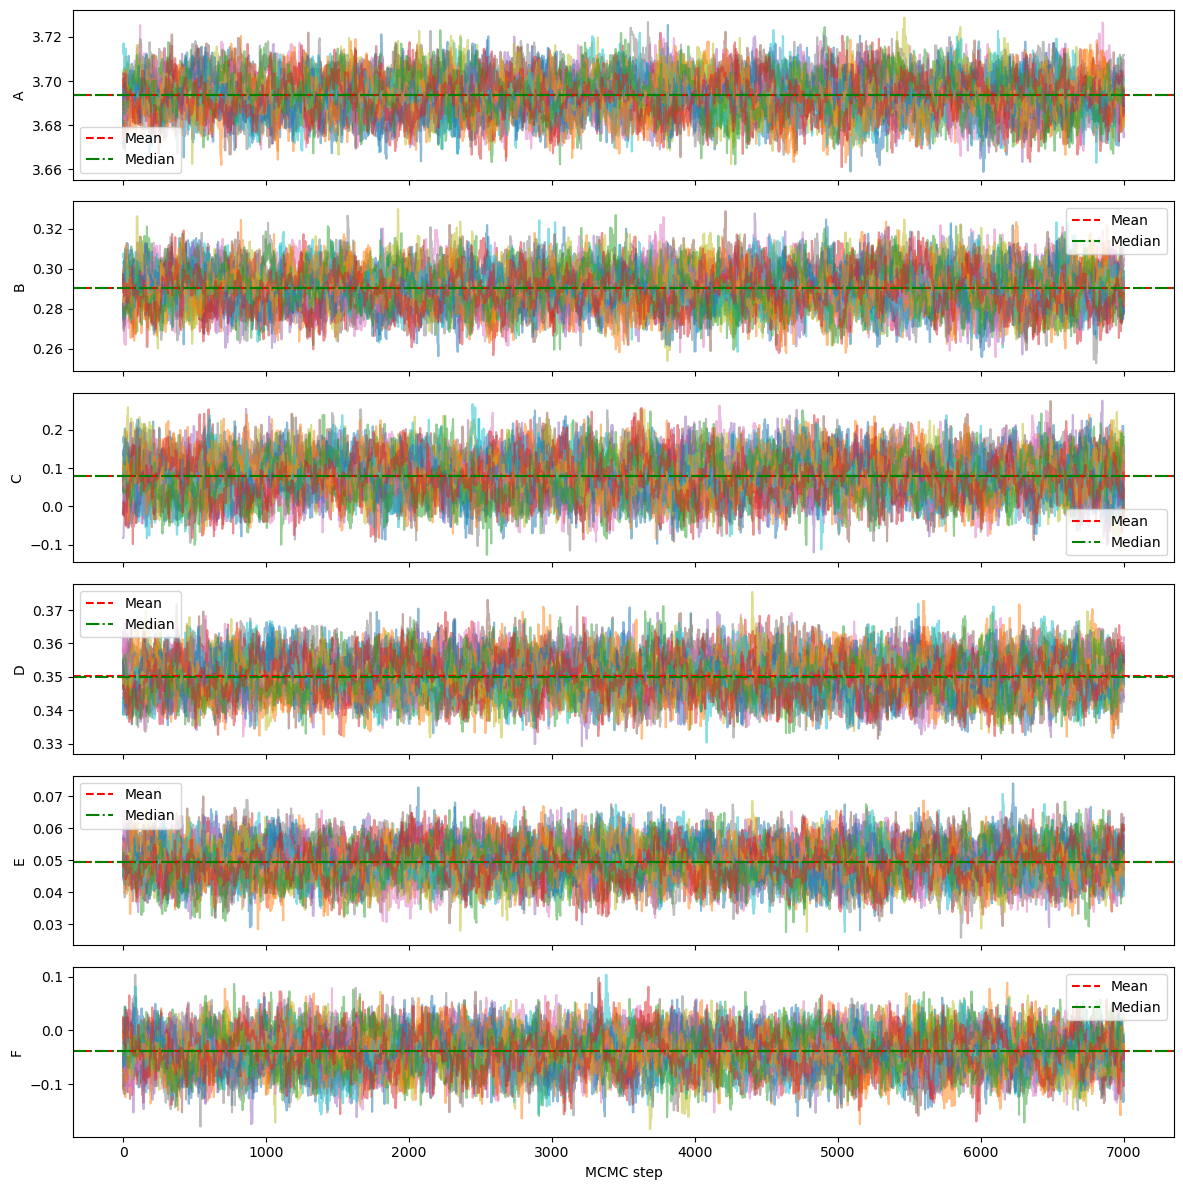

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

res = MCMC(richesse_bin=(20,100), 
           redshift_bin=(0.2,0.8), 
           itt=10000, redshift_params=True, correction=False, snr_cut = 10.0)

# Extract chains and statistics
chains = res['chains']  # shape: (nsteps, nwalkers, 6) or similar
means = res['mean']     # length 6
stds  = res['std']      # length 6

# Print best-fit values
param_names = ['A','B','C','D','E','F']
for i, name in enumerate(param_names):
    print(f"{name}: mean={means[i]:.4f}, std={stds[i]:.4f}")

# ------------------------------------------------------------------------------
# Plot chains to check convergence
# ------------------------------------------------------------------------------
n_params = 6
nsteps, nwalkers = chains.shape[0], chains.shape[1]

fig, axes = plt.subplots(n_params, 1, figsize=(12, 2*n_params), sharex=True)
for i in range(n_params):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(chains[:, w, i], alpha=0.5)
    # Show mean and median lines
    mean_i = np.mean(chains[:, :, i])
    median_i = np.median(chains[:, :, i])
    ax.axhline(mean_i, color='red', linestyle='--', label='Mean')
    ax.axhline(median_i, color='green', linestyle='-.', label='Median')
    ax.set_ylabel(param_names[i])
    ax.legend()
axes[-1].set_xlabel('MCMC step')
plt.tight_layout()
plt.show()


## Miscentering

In [16]:
cat_cl = ClCatalog('clusters', data=t_cl)
cat_halo = ClCatalog('halos', data=t_halo)
mt = MembershipMatch()
ang_sep = mt._get_dist_mt(cat_cl, cat_halo, "angular_proximity")  

print(f"Angular separation: min={np.min(ang_sep)}, max={np.max(ang_sep)}")

ang_sep_rad = np.deg2rad(ang_sep)

h = 0.71
Omega_c = 0.1109 / h**2     # 0.2198
Omega_b = 0.02258 / h**2    # 0.0448

cosmo_dc2 = ccl.Cosmology(
    Omega_c = Omega_c,
    Omega_b = Omega_b,
    h       = h,
    sigma8  = 0.8,
    n_s     = 0.963,
    m_nu    = 0.0,
    w0      = -1.0,
    wa      = 0.0
)

cosmo = clevar.cosmology.CCLCosmology(be_cosmo = cosmo_dc2)
#cosmo = clevar.cosmology.AstroPyCosmology()
R_off = cosmo.rad2mpc(ang_sep_rad, cat_halo['redshift'])

# Step 5 — Add to your table
t_cl_match['R_off'] = R_off

# Step 6 — Diagnostics
print(f"Max R_off [Mpc]: {np.max(R_off):.4f}")
print(f"Mean R_off [Mpc]: {np.mean(R_off):.4f}")
print(f"Median R_off [Mpc]: {np.median(R_off):.4f}")

# Step 7 — Histogram
plt.figure(figsize=(6,4))
plt.hist(R_off, bins=50)
plt.xlabel("R_off [Physical Mpc]")
plt.ylabel("Number of clusters")
plt.title("Cluster–Halo Offsets")
plt.show()

/sps/lsst/users/ebarroso/conda_envs/firecrown_clp/lib/python3.13/site-packages/clevar/catalog/tagdata.py:308: UserWarning: id column missing, additional one is being created.
  warnings.warn(f"{id_name} column missing, additional one is being created.")


KeyError: 'SkyCoord'

In [ ]:
R = np.array(t_cl_match['R_off'])  # in Mpc
def log_likelihood(theta, R):
    sigma = theta[0]
    if sigma <= 0:
        return -np.inf
    return np.sum(np.log(R / sigma**2) - R / sigma)

def log_prior(theta):
    sigma = theta[0]
    if 0 < sigma < 5.0:  # Mpc
        return 0.0
    return -np.inf

def log_posterior(theta, R):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, R)

# MCMC setup
ndim = 1  # only sigma
nwalkers = 32
nsteps = 50000
np.random.seed(42)
initial = 0.2 + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(R,))

samples_list = []
with tqdm(total=nsteps, desc="MCMC progress") as pbar:
    for sample in sampler.sample(initial, iterations=nsteps, progress=False):
        pbar.update(1)
    samples_list.append(sampler.get_chain())

samples = sampler.get_chain(discard=1000, flat=True)
sigma_mcmc = np.percentile(samples[:,0], [16, 50, 84])
print(f"Sigma offset: {sigma_mcmc[1]:.3f} +{sigma_mcmc[2]-sigma_mcmc[1]:.3f} -{sigma_mcmc[1]-sigma_mcmc[0]:.3f} Mpc")

sigma_best = sigma_mcmc[1]
R_plot = np.linspace(0, np.max(R), 100)
pdf = (R_plot / sigma_best**2) * np.exp(-R_plot / sigma_best)

plt.figure(figsize=(6,4))
plt.hist(R, bins=50, density=True, alpha=0.6, label="Data")
plt.plot(R_plot, pdf, 'r-', lw=2, label=f"Rayleigh fit: σ={sigma_best:.3f} Mpc")
plt.xlabel("R_off [Mpc]")
plt.ylabel("Probability density")
plt.legend()
plt.show()
cosmodc2_paper =  0.03 * (1.07*0.04 + 0.19 * 0.03 - 0.02*0.01 )
print(f"The paper offset is: {cosmodc2_paper}")

## Selection

In [ ]:
from crow import completeness_models
from crow import purity_models

purity_aguena = purity_models.PurityAguena16()
completeness_aguena = completeness_models.CompletenessAguena16()
###################### MCMC ########################
def log_prior(theta):
    """Define the search space for a_n, b_n, a_logm_piv, b_logm_piv."""
    a_n, b_n, a_logm_piv, b_logm_piv = theta
    # Example bounds: adjust based on your specific Aguena16 priors
    if -5.0 < a_n < 20.0 and -5.0 < b_n < 25.0 and 0.0 < a_logm_piv < 26.0 and 0.0 < b_logm_piv < 20.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, log_mass, z, observed_status):
    """
    observed_status: 1 if halo recovered, 0 if not.
    """
    # Update model parameters
    completeness_aguena.parameters["a_n"] = theta[0]
    completeness_aguena.parameters["b_n"] = theta[1]
    completeness_aguena.parameters["a_logm_piv"] = theta[2]
    completeness_aguena.parameters["b_logm_piv"] = theta[3]
    
    # Get the probability P(recovered | M, z)
    # Ensure log_mass and z are numpy arrays
    probs = completeness_aguena.distribution(log_mass, z)
    if np.any((probs <= 0) | (probs >= 1) | np.isnan(probs)):
        return -np.inf
    log_l = np.sum(observed_status * np.log(probs) + (1 - observed_status) * np.log(1 - probs))
    return log_l

def log_probability(theta, log_mass, z, observed_status):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, log_mass, z, observed_status)

## Completeness

In [ ]:
c1 = cat1
c1['log_halo_mass'] = np.log10(c1['halo_mass'])
print(np.min(c1['log_halo_mass'] ))
c2 = cat2
c2['log10_n200'] = np.log10(cat2['n200'])
#mt1, mt2 = get_matched_pairs(c1, c2, 'cross', None, None) 
redshift_col = 'redshift_true' 
mass_col = 'log_halo_mass'
#plot style
figx=10
figy=7
matching_selected = 'cross'
#recovery_plot
#zbins = np.linspace(0.2,1.5,14)
zbins = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1])
mbins = [13., 14., 14.5, 15.]
#zbins = np.linspace(0, 1.6, 9)
#mbins = np.logspace(14, 15, 5)
fig = plt.figure()#figsize=(figx,figy))
info_comp = r_cf.plot(c1, col1=redshift_col, col2=mass_col, bins1=zbins, bins2=mbins, matching_type=matching_selected, legend_format=lambda x: x, lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}])
info_comp['ax'].set_xlabel('$z_{halo}$')
info_comp['ax'].set_ylabel('Completeness') 
info_comp['ax'].set_ylim(0,1.2)
info_comp['ax'].set_xlim(0.2,1.6) 
info_comp['ax'].set_title('cross')
plt.show(fig)
# plt.savefig(outpath+'recovery_plot.png', bbox_inches='tight')
plt.close(fig)
print(info_comp['data'])

In [ ]:
edges_z = info_comp["data"]["edges1"]
edges_m = info_comp["data"]["edges2"]
recovery_matrix = info_comp["data"]["recovery"]


z_list = []
for i in range(len(edges_z) - 1):
    z_list.append((edges_z[i] + edges_z[i+1]) / 2.0)

m_list = []
for j in range(len(edges_m) - 1):
    m_list.append((edges_m[j] + edges_m[j+1]) / 2.0)

mcmc_z = []
mcmc_m = []
mcmc_rec = []

for i in range(len(z_list)):        # Loop over redshift bins
    for j in range(len(m_list)):    # Loop over mass bins
        mcmc_z.append(z_list[i])
        mcmc_m.append(m_list[j])
        mcmc_rec.append(recovery_matrix[i, j])

# Convert to numpy arrays for speed in the likelihood function
mcmc_z = np.array(mcmc_z)
mcmc_m = np.array(mcmc_m)
mcmc_rec = np.array(mcmc_rec)

print(f"Total data points for MCMC: {len(mcmc_rec)}")
print(mcmc_rec, mcmc_z, mcmc_m)

In [ ]:

n_params = 4
n_walkers = 60
n_steps = 20000

# Initial guess (center of the ball)
initial_guess = np.array([0.38, 1.26, 11.31, 0.20]) 
pos = initial_guess + 1e-4 * np.random.randn(n_walkers, n_params)

sampler = emcee.EnsembleSampler(
    n_walkers, n_params, log_probability, args=(mcmc_m, mcmc_z, mcmc_rec)
)

print("Running MCMC...")
sampler.run_mcmc(pos, n_steps, progress=True)
# Discard first 500 steps and flatten
flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)

# 1. Print Best Fit (Median and 1-sigma)
labels = ["a_n", "b_n", "a_logm_piv", "b_logm_piv"]
for i in range(n_params):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]}: {mcmc[1]:.4f} (+{q[1]:.4f}, -{q[0]:.4f})")

In [ ]:
##Purity

In [ ]:
redshift_cluster_col = "zp"
richness_cluster_col = "log10_n200"
rbins = np.log10([20, 35, 70, 100, 200])
#zbins = np.linspace(0, 1.6, 9)
#mbins = np.logspace(14, 15, 5)
fig = plt.figure()
info_pur = r_cf.plot(c2, col1=redshift_cluster_col, col2=richness_cluster_col, bins1=zbins, bins2=rbins, matching_type=matching_selected, lines_kwargs_list = [{'color':'black'}, {'color':'red'}, {'color':'blue'}, {'color':'purple'}])
info_pur['ax'].set_xlabel('$z_{cl}$')
info_pur['ax'].set_ylabel('Purity') 
info_pur['ax'].set_ylim(0.5,1.2)
info_pur['ax'].set_xlim(0.2,1.6) 
info_pur['ax'].set_title('cross')
plt.show(fig)
plt.close(fig)
print(info_pur["data"])

In [ ]:
from crow import completeness_models
from crow import purity_models

purity_aguena = purity_models.PurityAguena16()
completeness_aguena = completeness_models.CompletenessAguena16()
###################### MCMC ########################
def log_prior(theta):
    """Define the search space for a_n, b_n, a_logm_piv, b_logm_piv."""
    a_n, b_n, a_logm_piv, b_logm_piv = theta
    # Example bounds: adjust based on your specific Aguena16 priors
    if -5.0 < a_n < 20.0 and -5.0 < b_n < 25.0 and 0.0 < a_logm_piv < 26.0 and -2.0 < b_logm_piv < 20.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, log_mass, z, observed_status):
    """
    observed_status: 1 if halo recovered, 0 if not.
    """
    # Update model parameters
    purity_aguena.parameters["a_n"] = theta[0]
    purity_aguena.parameters["b_n"] = theta[1]
    purity_aguena.parameters["a_logm_piv"] = theta[2]
    purity_aguena.parameters["b_logm_piv"] = theta[3]
    
    # Get the probability P(recovered | M, z)
    # Ensure log_mass and z are numpy arrays
    probs = purity_aguena.distribution(log_mass, z)
    if np.any((probs <= 0) | (probs >= 1) | np.isnan(probs)):
        return -np.inf
    
    # Bernoulli Log-Likelihood: sum(y*log(p) + (1-y)*log(1-p))
    log_l = np.sum(observed_status * np.log(probs) + (1 - observed_status) * np.log(1 - probs))
    return log_l

def log_probability(theta, log_mass, z, observed_status):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, log_mass, z, observed_status)

In [ ]:
edges_z = info_pur["data"]["edges1"]
edges_m = info_pur["data"]["edges2"]
recovery_matrix = info_pur["data"]["recovery"]


z_list = []
for i in range(len(edges_z) - 1):
    z_list.append((edges_z[i] + edges_z[i+1]) / 2.0)

m_list = []
for j in range(len(edges_m) - 1):
    m_list.append((edges_m[j] + edges_m[j+1]) / 2.0)

mcmc_z = []
mcmc_m = []
mcmc_rec = []

for i in range(len(z_list)):        # Loop over redshift bins
    for j in range(len(m_list)):    # Loop over mass bins
        mcmc_z.append(z_list[i])
        mcmc_m.append(m_list[j])
        mcmc_rec.append(recovery_matrix[i, j])

# Convert to numpy arrays for speed in the likelihood function
mcmc_z = np.array(mcmc_z)
mcmc_m = np.array(mcmc_m)
mcmc_rec = np.array(mcmc_rec)

print(f"Total data points for MCMC: {len(mcmc_rec)}")

In [ ]:

n_params = 4
n_walkers = 60
n_steps = 20000

# Initial guess (center of the ball)
initial_guess = np.array([3.9193, 1.26, 1.31, -0.20]) 
pos = initial_guess + 1e-4 * np.random.randn(n_walkers, n_params)

sampler = emcee.EnsembleSampler(
    n_walkers, n_params, log_probability, args=(mcmc_m, mcmc_z, mcmc_rec)
)

print("Running MCMC...")
sampler.run_mcmc(pos, n_steps, progress=True)
# Discard first 500 steps and flatten
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

# 1. Print Best Fit (Median and 1-sigma)
labels = ["a_n", "b_n", "a_logm_piv", "b_logm_piv"]
for i in range(n_params):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{labels[i]}: {mcmc[1]:.4f} (+{q[1]:.4f}, -{q[0]:.4f})")